In [30]:
import os
import random
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
import time
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

# Set seed for reproducibility
random.seed(42)

# Check if CUDA is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

In [ ]:

# Set model dimensions based on selected model
ModelName = 'MiniLM'  # Options: 'MiniLM', 'Nomic', 'Mpnet', 'Gte-small', 'Gte-base', 'Gte-large'
NomicDim = 768

# Model selection and corresponding configurations
if ModelName == 'MiniLM':
    tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
    model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device)
    Dim = 384

    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def embed_sentence(sentence):
        encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        return sentence_embeddings

elif ModelName == 'Nomic':
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('Nomic-ai/Nomic-embed-text-v1.5', trust_remote_code=True, safe_serialization=True).to(device)
    model.eval()
    Dim = NomicDim

    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def embed_sentence(sentence):
        encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt').to(device)
        matryoshka_dim = NomicDim
        with torch.no_grad():
            model_output = model(**encoded_input)
            embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
            embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
            embeddings = embeddings[:, :matryoshka_dim]
            embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

elif ModelName == 'Mpnet':
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
    model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(device)
    Dim = 768

    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def embed_sentence(sentence):
        encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings

elif ModelName == 'Gte-small':
    tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
    model = AutoModel.from_pretrained("thenlper/gte-small").to(device)
    Dim = 384

    def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

    def embed_sentence(sentence):
        encoded_input = tokenizer(sentence, max_length=512, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
            sentence_embeddings = average_pool(model_output.last_hidden_state, encoded_input['attention_mask'])
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings

elif ModelName == 'Gte-base':
    tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-base")
    model = AutoModel.from_pretrained("thenlper/gte-base").to(device)
    Dim = 768

    def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

    def embed_sentence(sentence):
        encoded_input = tokenizer(sentence, max_length=512, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
            sentence_embeddings = average_pool(model_output.last_hidden_state, encoded_input['attention_mask'])
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings

elif ModelName == 'Gte-large':
    tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-large")
    model = AutoModel.from_pretrained("thenlper/gte-large").to(device)
    Dim = 1024

    def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

    def embed_sentence(sentence):
        encoded_input = tokenizer(sentence, max_length=512, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
            sentence_embeddings = average_pool(model_output.last_hidden_state, encoded_input['attention_mask'])
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings

# Define paths
dataPath = 'Data/Enron/emails.csv'
savePath = f'Results/EnronEmbeddingSpace/{ModelName}EnronEmbeddingsSpace'

# Create directory if it does not exist
if not os.path.exists(savePath):
    os.makedirs(savePath)


# Load the Dataset and set directories

In [ ]:
# Load the dataset and limit to 2000 messages
df = pd.read_csv(dataPath)
inputs = df['message'].tolist()[:2000]

embedding_list = []
time_start = time.time()

# Loop through the inputs and embed each message
for i, doc in enumerate(inputs):
    embedding = embed_sentence(doc)  # Embed the sentence
    embedding_list.append(embedding)
    
    # Provide progress update every 100 documents
    if i % 100 == 0:
        print(f'{i} documents processed, time taken: {time.time() - time_start:.2f} seconds')
        time_start = time.time()

# Concatenate all embeddings into a single tensor
embeddings = torch.cat(embedding_list, dim=0)

# Save the embeddings to a file
torch.save(embeddings, f'{savePath}/embeddings.pt')
print(f'Embeddings saved successfully to {savePath}/embeddings.pt')


# Calculate Statistics

In [ ]:
# Calculate sum and average for each sentence embedding
sums = embeddings.sum(dim=1)
averages = embeddings.mean(dim=1)

# Convert sums and averages to lists for easier inspection if needed
sums_list = sums.tolist()
averages_list = averages.tolist()

# Display summary statistics of the sums and averages
print(f'Total sum of all embeddings: {sums.sum().item()}')
print(f'Average sum per embedding: {sums.mean().item()}')
print(f'Average of all averages: {averages.mean().item()}')

# Calculate detailed statistics for each embedding dimension (across all sentences)
mean = embeddings.mean(dim=0)
median = embeddings.median(dim=0)[0]
min_val = embeddings.min(dim=0)[0]
max_val = embeddings.max(dim=0)[0]
variance = embeddings.var(dim=0)

# Create a DataFrame to store the calculated statistics
stats_df = pd.DataFrame({
    'mean': mean.tolist(),
    'median': median.tolist(),
    'min': min_val.tolist(),
    'max': max_val.tolist(),
    'variance': variance.tolist()
})

# Save the statistics to a CSV file for future reference
stats_df.to_csv(f'{savePath}/embedding_statistics.csv', index=False)
print(f'Statistics saved successfully to {savePath}/embedding_statistics.csv')


# Plot the statistics

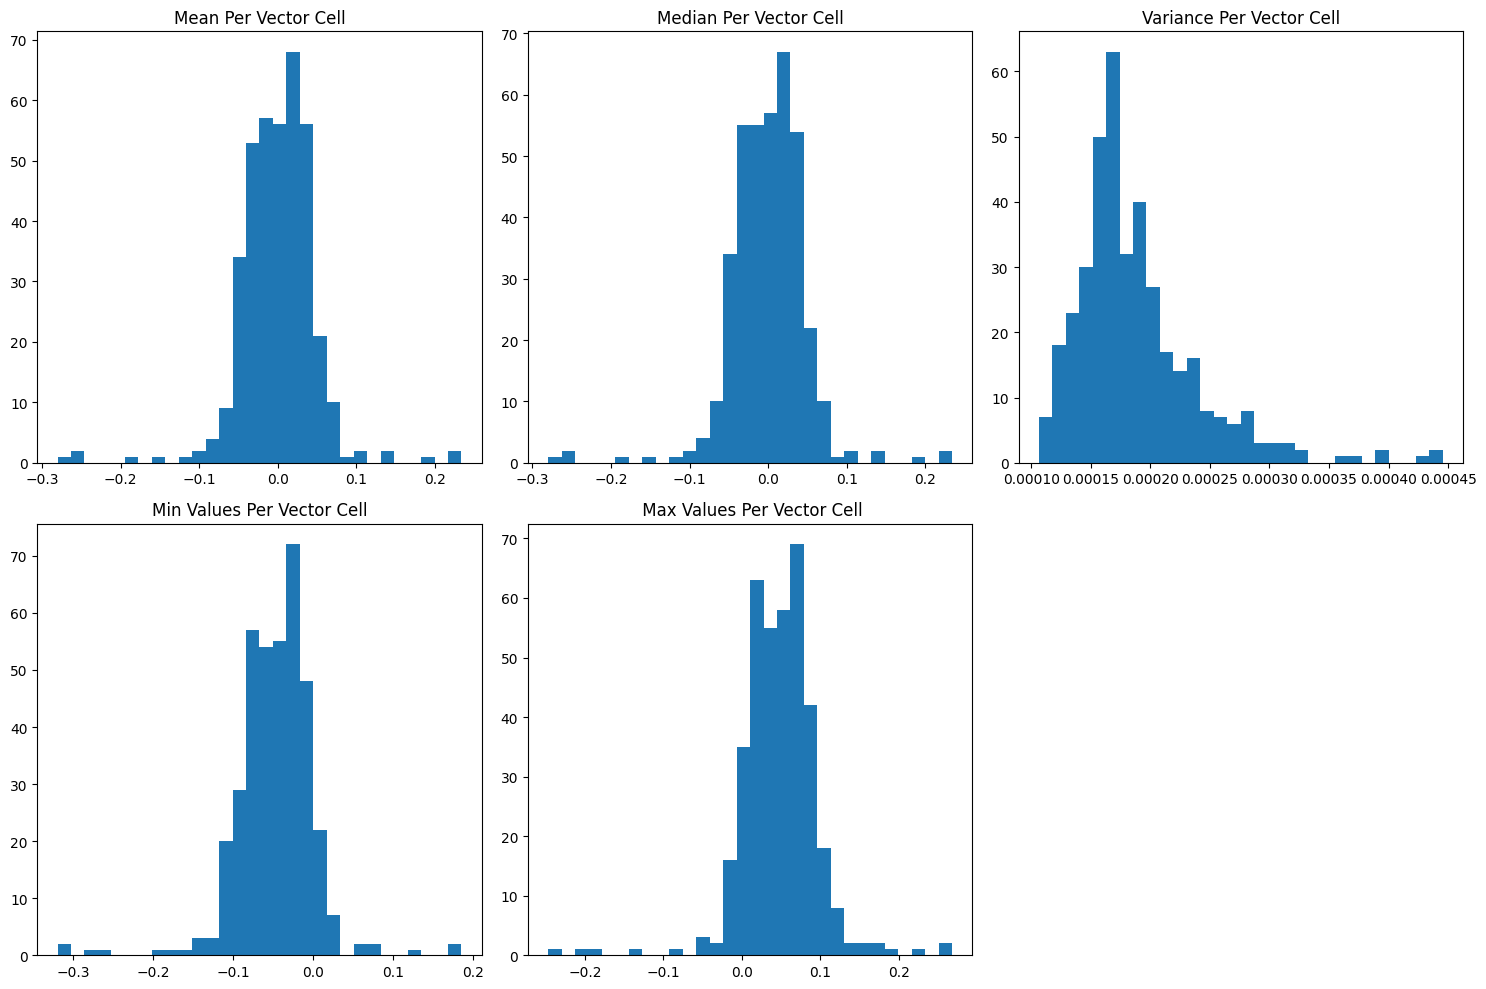

In [35]:
# Plot the statistics of the embeddings
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# First row - Histograms for Mean, Median, and Variance
axs[0, 0].hist(mean.cpu().numpy(), bins=30)
axs[0, 0].set_title('Mean Per Vector Cell')

axs[0, 1].hist(median.cpu().numpy(), bins=30)
axs[0, 1].set_title('Median Per Vector Cell')

axs[0, 2].hist(variance.cpu().numpy(), bins=30)
axs[0, 2].set_title('Variance Per Vector Cell')

# Second row - Histograms for Min and Max values
axs[1, 0].hist(min_val.cpu().numpy(), bins=30)
axs[1, 0].set_title('Min Values Per Vector Cell')

axs[1, 1].hist(max_val.cpu().numpy(), bins=30)
axs[1, 1].set_title('Max Values Per Vector Cell')

# Remove the unused subplot
fig.delaxes(axs[1, 2])

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Save the plot as an image file
fig.savefig(f'{savePath}/embedding_statistics.png')
print(f'Plot saved to {savePath}/embedding_statistics.png')
